## SIMPLIFIED StackOverFlow Developer Survey Analysis

In [2]:
import pandas as pd
from pathlib import Path
from datetime import datetime
import requests
import zipfile
import shutil
import os

import numpy as np
import matplotlib.pyplot as plt

In [3]:
# filter the warning for now on
#import warnings
#warnings.simplefilter("ignore", DeprecationWarning)

# new way to create an ordered category
from pandas.api.types import CategoricalDtype

## OVERVIEW

As the business world adapts to the massive disrutption of internet and the consumer epxectations driven by unleashed by the first movers and innovators in Tech, DATA SCIENTISTS have become hightly sought after.  This has made it a very attractive career building on the customs and tools pioneered by individuals in Academic Science and Computer Programming disciplines. 

QUESTION: Data Science is a hot field, however, are the people doing "the best job in America" different from other developers?  Are the people doing it different?  That is, are their attitudes and aproaches of Data Scientists different from other coders and tech geeks?


---
## DATASET Description:

The data set is the full, cleaned results of the 2019 Stack Overflow Developer Survey. The data can be downloaded from: <https://insights.stackoverflow.com/survey>.  are in the external subdirectory. Free response submissions and personally identifying information have been removed from the results to protect the privacy of respondents. 

The survey was fielded from January 23 to February 14, 2019. The median time spent on the survey for qualified responses was 23.3 minutes.

Respondents were recruited primarily through channels owned by Stack Overflow. The top 5 sources of respondents were onsite messaging, blog posts, email lists, Meta posts, banner ads, and social media posts. Since respondents were recruited in this way, highly engaged users on Stack Overflow were more likely to notice the links for the survey and click to begin it.


---
### Data Files

There are two main files of interest --
1. survey_results_public.csv - CSV file with main survey results, one respondent per row and one column per answer
2. survey_results_schema.csv - CSV file with survey schema, i.e., the questions that correspond to each column name

which we will download and prepare for analysis.

In [4]:
today = datetime.today()
survey_year = 2019
# in case we want to reuse code for other years
in_file = Path.cwd() / 'data' / 'raw' / f'survey{survey_year}.csv'
# this is where our cleaned up file will put put
summary_file = Path.cwd() / 'data' / 'processed' / \
    f'summary_{today:%b-%d-%Y}.pkl'

In [5]:
# download the data if its not in the local directory

if not os.path.exists(in_file):
    # put these here in case we want to look at any other years...
    url = 'https://drive.google.com/uc?export=download&id=1QOmVDpd8hcVYqqUXDXf68UMDWQZP0wQV'
    survey_filename = 'survey_results_public.csv'
    questions_filename = 'survey_results_schema.csv'
    print('Downloading {} survey'.format(survey_year))

    request = requests.get(url)
    with open('survey.zip', 'wb') as file:
        file.write(request.content)

    print('Unzipping {} survey'.format(survey_year))
    with zipfile.ZipFile("survey.zip", "r") as file:
        file.extractall("data/external/")

    print('Moving {} survey'.format(year))
    shutil.copytree('data/external', 'data/raw')
    shutil.copy('data/external/' + survey_filename,
                'data/raw/survey{}.csv'.format(survey_year))
    shutil.copy('data/external/' + questions_filename,
                'data/raw/schema{}.csv'.format(survey_year))

    print('cleaning up')
    os.remove('survey.zip')

---
##  EXPLORE 1: Clean and Simplify Data

- 
- Remove all leading and trailing spaces (not nescessary)
- Rename the columns for consistency (not nescessary)
- Convert objects to category

# EXPLORE: Describe the Data (and clean/simplify) 
1. Describe your dataset. Describe and explore your dataset in the initial section of your Report. What does your data contain and what is its background? Where does it come from? Why is it interesting or significant? Conduct summary statistics and produce visualizations for the particular variables from the dataset that you will use.    
    

In [6]:
# beware that the Respondent ids start at 1
df = pd.read_csv(in_file, index_col='Respondent')

In [7]:
# Print column name
df.columns

Index(['MainBranch', 'Hobbyist', 'OpenSourcer', 'OpenSource', 'Employment',
       'Country', 'Student', 'EdLevel', 'UndergradMajor', 'EduOther',
       'OrgSize', 'DevType', 'YearsCode', 'Age1stCode', 'YearsCodePro',
       'CareerSat', 'JobSat', 'MgrIdiot', 'MgrMoney', 'MgrWant', 'JobSeek',
       'LastHireDate', 'LastInt', 'FizzBuzz', 'JobFactors', 'ResumeUpdate',
       'CurrencySymbol', 'CurrencyDesc', 'CompTotal', 'CompFreq',
       'ConvertedComp', 'WorkWeekHrs', 'WorkPlan', 'WorkChallenge',
       'WorkRemote', 'WorkLoc', 'ImpSyn', 'CodeRev', 'CodeRevHrs', 'UnitTests',
       'PurchaseHow', 'PurchaseWhat', 'LanguageWorkedWith',
       'LanguageDesireNextYear', 'DatabaseWorkedWith',
       'DatabaseDesireNextYear', 'PlatformWorkedWith',
       'PlatformDesireNextYear', 'WebFrameWorkedWith',
       'WebFrameDesireNextYear', 'MiscTechWorkedWith',
       'MiscTechDesireNextYear', 'DevEnviron', 'OpSys', 'Containers',
       'BlockchainOrg', 'BlockchainIs', 'BetterLife', 'ITperson', 

### zero order sanity checks
First lets see what features are in here, and see how complete it is... empty (`NaN`) entries...  complete columns... and columns with lots of missing data. 

In [8]:
# what pct of of empty entries..
(100 * df.isna().sum() / df.shape[0]).describe()

count    84.000000
mean     13.780154
std      12.171536
min       0.000000
25%       2.128078
50%      10.792277
75%      22.270007
max      45.799534
dtype: float64

In [9]:
# check columns with no missing values
set(df.isna().sum()[df.isna().sum() == 0].keys())

{'Hobbyist', 'OpenSourcer'}

In [10]:
# check which columns have over 50% missing values
sum(df.columns[100*df.isna().sum()/df.shape[0] > 50])

0

### Almost all of the features are categorical

We can lump the variables into a few rough categories -- _DEMOGRAPHIC_, _WORK_ , _CODING_, _ATTITUDINAL_ (personal), _STACKOVERFLOW_, and _MISC_.  We'll focus in on DEMOGRAPHICS, CODING, and ATTITUDINAL features.  Features of most interest are `tagged` below.

> _DEMOGRAPHIC_ - `MainBranch`, `Age`, `Gender`, `Trans','Sexuality', 'Ethnicity', 'Dependents', 'Country', 'Student', 'EdLevel', 'UndergradMajor`, 'EduOther, 

> _ATTITUDINAL_ (personal) -  `ImpSyn'(personal competence), 'CareerSat', 'JobSat', 'MgrIdiot', 'MgrMoney', 'MgrWant', 'JobFactors', 'BlockchainIs', 'BetterLife', 'ITperson', 'OffOn',  'SocialMedia', 'Extraversion', 'ScreenName', 'OpenSource`  

> _WORK_ related - `ConvertedComp',  'WorkWeekHrs' 'Employment', 'OrgSize`, (also:  'JobSeek', 'LastHireDate', 'LastInt',  'ResumeUpdate',   'CompTotal',    'CurrencySymbol', 'CurrencyDesc', 'CompTotal', 'CompFreq',, 'WorkPlan', 'WorkChallenge', 'WorkRemote', 'WorkLoc', 'CodeRev', 'CodeRevHrs', 'UnitTests','PurchaseHow', 'PurchaseWhat', 
       
> _CODING_ related -  `YearsCode', 'Age1stCode`, `YearsCodePro`,`OpenSourcer', 'DevType',  'LanguageWorkedWith', 'LanguageDesireNextYear','DevEnviron', 'OpSys', 'Containers', 'DatabaseWorkedWith', 'DatabaseDesireNextYear', 'PlatformWorkedWith',   'PlatformDesireNextYear',  MiscTechWorkedWith', 'MiscTechDesireNextYear', 'BlockchainOrg`, ( 
       'WebFrameWorkedWith',     'WebFrameDesireNextYear', ', , 'FizzBuzz', )
    
> *MISC* - `Hobbyist', 'SurveyLength', 'SurveyEase`
      
> _STACKOVERFLOW_ specific -  Ignore all these ('SOVisit1st','SOVisitFreq', 'SOVisitTo', 'SOFindAnswer', 'SOTimeSaved',       'SOHowMuchTime', 'SOAccount', 'SOPartFreq', 'SOJobs', 'EntTeams',       'SOComm', 'WelcomeChange', 'SONewContent')
    
Keep DEMOGRAPHIC, some WORK related, CODING, and MISC for further analysis.

Convert the "object" columns to 'category' columns for efficiency and to analyze.  Because our featurs are categorical instead of numbers we won't really be using vanilla Gaussian statistical summaries and stats.  one-hotting and logistic regression will be tried. 
       
        

In [11]:
# only convert categories we want to analyze...
convert_to_cat = ['MainBranch', 'Gender', 'Trans', 'Sexuality', 'Ethnicity', 'Dependents', 'Student', 'UndergradMajor',
                  'Employment',  'OrgSize',
                  'CareerSat', 'BlockchainOrg', 'OpSys', 'OpenSourcer',
                  'MgrIdiot', 'MgrMoney', 'MgrWant', 'BlockchainIs', 'BetterLife', 'ITperson', 'OffOn', 'ScreenName', 'SocialMedia', 'Extraversion',
                  'SurveyLength', 'SurveyEase', 'Hobbyist']
# 'EdLevel','OpenSource','JobSat','ImpSyn',
# convert to categories
for col_name in convert_to_cat:
    if(df[col_name].dtype == 'object'):
        df[col_name] = df[col_name].astype('category')
        # df2.loc[:,col_name] = df[col_name].cat.codes  # could do this

In [12]:
# Convert these to ordered categories
# Education
edlevel_cat = CategoricalDtype(['I never completed any formal education',
                                'Primary/elementary school',
                                'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)',
                                'Some college/university study without earning a degree',
                                'Associate degree',
                                'Bachelor’s degree (BA, BS, B.Eng., etc.)',
                                'Master’s degree (MA, MS, M.Eng., MBA, etc.)',
                                'Professional degree (JD, MD, etc.)',
                                'Other doctoral degree (Ph.D, Ed.D., etc.)'], ordered=True)

df['EdLevel'] = df.EdLevel.astype(edlevel_cat)

In [13]:
df['MainBranch'].value_counts()

I am a developer by profession                                                   65679
I am a student who is learning to code                                           10189
I am not primarily a developer, but I write code sometimes as part of my work     7539
I code primarily as a hobby                                                       3340
I used to be a developer by profession, but no longer am                          1584
Name: MainBranch, dtype: int64

In [14]:
df['EdLevel'].value_counts()

Bachelor’s degree (BA, BS, B.Eng., etc.)                                              39134
Master’s degree (MA, MS, M.Eng., MBA, etc.)                                           19569
Some college/university study without earning a degree                                10502
Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)     8642
Associate degree                                                                       2938
Other doctoral degree (Ph.D, Ed.D., etc.)                                              2432
Primary/elementary school                                                              1422
Professional degree (JD, MD, etc.)                                                     1198
I never completed any formal education                                                  553
Name: EdLevel, dtype: int64

In [15]:
# seems like the incidence seems pretty gen-pop representative.. maybe higher bi than gay..
# might want to loook deeper at respondents who chose BOTH straight and Gay / Bi

100*df['Sexuality'].value_counts() / df.shape[0]

Straight / Heterosexual                            78.929604
Bisexual                                            3.870256
Gay or Lesbian                                      2.022884
Bisexual;Straight / Heterosexual                    0.555787
Bisexual;Gay or Lesbian                             0.128258
Bisexual;Gay or Lesbian;Straight / Heterosexual     0.121508
Gay or Lesbian;Straight / Heterosexual              0.042753
Name: Sexuality, dtype: float64

In [16]:
# pretty decent ammount of diversity
(100*df['Country'].value_counts()/df.shape[0]).head(10)

United States     23.569186
India             10.194300
Germany            6.599687
United Kingdom     6.454553
Canada             3.819628
France             2.690053
Brazil             2.191645
Poland             2.162393
Australia          2.141017
Netherlands        2.083638
Name: Country, dtype: float64

In [17]:
# OpenSource . Higher, same lower
opensource_cat = CategoricalDtype(['OSS is, on average, of HIGHER quality than proprietary / closed source software',
                                   'The quality of OSS and closed source software is about the same',
                                   'OSS is, on average, of LOWER quality than proprietary / closed source software', ], ordered=True)
df['OpenSource'] = df.OpenSource.astype(opensource_cat)

In [18]:
# career satisfaction / job satisfaction\
careersat_cat = CategoricalDtype(['Very dissatisfied',
                                  'Slightly dissatisfied',
                                  'Neither satisfied nor dissatisfied',
                                  'Slightly satisfied',
                                  'Very satisfied'], ordered=True)
df['CareerSat'] = df.CareerSat.astype(careersat_cat)

jobsat_cat = CategoricalDtype(['Very dissatisfied',
                               'Slightly dissatisfied',
                               'Neither satisfied nor dissatisfied',
                               'Slightly satisfied',
                               'Very satisfied'], ordered=True)
df['JobSat'] = df.JobSat.astype(jobsat_cat)

In [19]:
# competence
impsyn_cat = CategoricalDtype(['Far below average',
                               'A little below average',
                               'Average',
                               'A little above average',
                               'Far above average'], ordered=True)
df['ImpSyn'] = df.ImpSyn.astype(impsyn_cat)

In [20]:
print('The dataset contains', df.shape[0], 'rows and', df.shape[1], 'columns.')

The dataset contains 88883 rows and 84 columns.


### categorical variables
# Research Questions

2. Ask and answer analytic questions. Ask three analytic questions and answer each one with a combination of statistics and visualizations. These analytic questions can focus on individuals behaviors or comparisons of the population.



----
## Time to zero in on our questoin... 

The motivation behind this analysis is to explore how data scientists compare with non-data scientist developers ("non-data scientists"). Consequently, we set out to answer the following questions:

1. are there demographic differences.  hypothesis is higher educated and more likely from math/science than computer/tech.  also younger/less experienced.
2. are their attitudes different? 
3. are their work situations different?
3. can we predict if a developer professional developer is a Data Scientist?

### Respondent Cleanup

- KEEP PROFESSIONALS ONLY.  Dropped students and "other"
- Create our categories of respondents (aux columns)
    - DataScientist
    - Non-DataScientists (everybody else, including un-engaged, jokers, and students)
    - Developers (other "professionals")


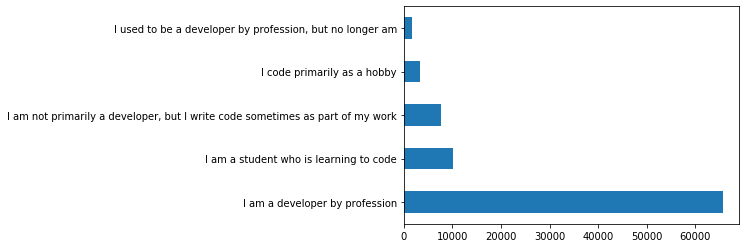

In [21]:
df['MainBranch'].value_counts().plot('barh')

As we are interested in comparing data scientists to non-data scientists, we need to be able to differentiate between the two. This is done using the `DevType` field. As a result, we should drop any rows where this field is missing, since we can't determine which subset these rows fit into.


In [22]:
# make some of the categories ordered
# df['MainBranch'].cat.categories[0]
developers = df['MainBranch'] == 'I am a developer by profession'
# limit our scope to professional developers
df = df[developers]

In [23]:
print('The dataset contains', df.shape[0], 'rows and', df.shape[1], 'columns.')

The dataset contains 65679 rows and 84 columns.


In [24]:
# Create data scientist and non-data scientist subsets.
# data scientists are defined as "Data or business analyst",Engineer, Data",
#       "Data scientist or machine learning specialist"
# Database administrator or Scientist

# developer is "Developer, {fullstack, game or graphics, mobile, QA or test}"
data_scientist = df['DevType'].str.contains('|'.join(
    ['data ', 'scientist']), case=False, na=False, regex=True).copy()  # data scientists / analists / Data engineers
# maybe exclude database administrator...
# how to deal with peopl who are _BOTH_

# data = df['DevType'].str.contains('data', case=False, na=False, regex=True).copy() #data scientists / analists / Data engineers
developer = df['DevType'].str.contains(
    'developer', case=False, na=False, regex=True).copy()  # all types of developers


print('we have {} DataScientists and {} traditional Developers in our professional Developers database'.format(
      data_scientist.sum(), developer.sum()))

we have 8057 DataScientists and 61987 traditional Developers in our professional Developers database


In [25]:
# its way too messy to parse through the multi-selects...
df.DevType[data_scientist].value_counts().head(15)  # .plot('barh')

Data scientist or machine learning specialist                                              333
Data scientist or machine learning specialist;Developer, back-end                          175
Data or business analyst;Data scientist or machine learning specialist                     106
Data scientist or machine learning specialist;Developer, full-stack                        100
Data scientist or machine learning specialist;Developer, back-end;Engineer, data            89
Data or business analyst                                                                    76
Data or business analyst;Developer, back-end                                                74
Data or business analyst;Developer, full-stack                                              73
Data scientist or machine learning specialist;Engineer, data                                66
Data scientist or machine learning specialist;Developer, back-end;Developer, full-stack     43
Data or business analyst;Data scientist or machine

In [27]:
df.DevType[developer].value_counts().head(15)


Developer, full-stack                                                                                           8077
Developer, back-end                                                                                             4703
Developer, back-end;Developer, front-end;Developer, full-stack                                                  2329
Developer, mobile                                                                                               2061
Developer, front-end                                                                                            2035
Developer, back-end;Developer, full-stack                                                                       1994
Developer, front-end;Developer, full-stack                                                                       989
Developer, desktop or enterprise applications                                                                    907
Developer, back-end;Developer, desktop or enterprise application

In [29]:
# make some expository columns
df.loc[:, 'DSorDV'] = np.nan

df.loc[data_scientist, 'DSorDV'] = 'Data Scientist'
df.loc[developer, 'DSorDV'] = 'Developer'

df.loc[:, 'isDS'] = data_scientist
df.loc[:, 'isDev'] = developer
df.loc[:, 'notDS'] = ~data_scientist
df['DSorDV'].value_counts()

Developer         61987
Data Scientist     1301
Name: DSorDV, dtype: int64

In [30]:
# where are resespondents from?
(100*df.loc[data_scientist, 'Country'].value_counts()/data_scientist.sum()).head(10)


United States     27.119275
India              8.911506
Germany            6.578131
United Kingdom     5.647263
Canada             3.711059
Brazil             2.594018
France             2.432667
Australia          2.345786
Netherlands        2.184436
Poland             1.911381
Name: Country, dtype: float64

In [31]:
(100*df.loc[developer, 'Country'].value_counts()/developer.sum()).head(10)

United States     24.217981
India             10.076306
United Kingdom     6.741736
Germany            6.501363
Canada             3.805637
France             2.640876
Brazil             2.363399
Poland             2.332747
Australia          2.158517
Netherlands        2.082695
Name: Country, dtype: float64

RESULTS:       
       
1.0.1.

1. How does the demographic profile of data scientists differ from that of non-data scientists?
> - male/female ratio
> - incident of out "other"/trans
> - dependents
> - US vs other
>

2. What programming languages do data scientists favour and how do they differ from those used by non-data scientists?
> - histograms

3. How much coding experience do data scientists have compared to non-data scientists?
> - years experience
> - age first code
4. Are data scientists more satisfied with their jobs/careers than non-data scientists?
> - salary
> - feelings of managers

5. Life shit
> - dependents
> -impsyn
> -fizzbuzz

### Create derived data columns

- Simplify some categories
    - Education: Advanced, College, Grade
    - Major: Computer/Tech, Math/Science, Other
        
- generation (from Age)
   - Age->Gen: GenZ,Milennial,GenX,Boomer,Silent
           

In [190]:
print('The dataset contains', df.shape[0], 'rows and', df.shape[1], 'columns.')

The dataset contains 65679 rows and 65 columns.


In [191]:
#df['EdLevel'].cat.categories

In [215]:
# simple method comparing strings... could also use ordering...
advanced = df['EdLevel'].isin(['Other doctoral degree (Ph.D, Ed.D., etc.)',
                               'Master’s degree (MA, MS, M.Eng., MBA, etc.)',
                               'Professional degree (JD, MD, etc.)'])

college = df['EdLevel'].isin(['Associate degree',
                              'Bachelor’s degree (BA, BS, B.Eng., etc.)',
                              'Some college/university study without earning a degree'])

grade = df['EdLevel'].isin(['Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)',
                            'Primary/elementary school',
                            'I never completed any formal education'])
no_answer = df['EdLevel'].isnull()

print('The dataset contains',  advanced.sum(),
      'respondents with advanced degrees, (n=', college.sum(),
      'college; n=', grade.sum(), 'grade) ', (advanced.sum()+college.sum()+grade.sum()+no_answer.sum()),
      'og~', df.shape[0],
      'null->', no_answer.sum())

The dataset contains 18295 respondents with advanced degrees, (n= 42115 college; n= 4016 grade)  65679 og~ 65679 null-> 1253


In [216]:
# create ordered category
edlevel_simple_cat = CategoricalDtype(['Grade',
                                       'College',  # 'N/A'
                                       'Advanced'], ordered=True)
df.loc[:, 'Education'] = np.nan

df.loc[advanced, 'Education'] = 'Advanced'
df.loc[college, 'Education'] = 'College'
df.loc[grade, 'Education'] = 'Grade'
#df.loc[no_answer,'Education'] = 'N/A'
#df.loc[:,'Education'] = np.nan
# now make it an ordered category
df.loc[:, 'Education'] = df.Education.astype(edlevel_simple_cat)

df['EdLevel'].value_counts()


Bachelor’s degree (BA, BS, B.Eng., etc.)                                              32582
Master’s degree (MA, MS, M.Eng., MBA, etc.)                                           15936
Some college/university study without earning a degree                                 7376
Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)     3373
Associate degree                                                                       2157
Other doctoral degree (Ph.D, Ed.D., etc.)                                              1468
Professional degree (JD, MD, etc.)                                                      891
Primary/elementary school                                                               331
I never completed any formal education                                                  312
Name: EdLevel, dtype: int64

In [217]:
df.loc[:, 'Major'] = np.nan

computer_tech = df['UndergradMajor'].isin(['Computer science, computer engineering, or software engineering',
                                           'Web development or web design',
                                           'Information systems, information technology, or system administration'])


math_sci = df['UndergradMajor'].isin(['Mathematics or statistics',
                                      'Another engineering discipline (ex. civil, electrical, mechanical)',
                                      'A natural science (ex. biology, chemistry, physics)'])

other = df['UndergradMajor'].isin(['A health science (ex. nursing, pharmacy, radiology)',
                                   'A business discipline (ex. accounting, finance, marketing)',
                                   'A humanities discipline (ex. literature, history, philosophy)',
                                   'A social science (ex. anthropology, psychology, political science)',
                                   'Fine arts or performing arts (ex. graphic design, music, studio art)'])


df.loc[computer_tech, 'Major'] = 'Computer/Tech'
df.loc[math_sci, 'Major'] = 'Math/Science'
df.loc[other, 'Major'] = 'Other'
#df.loc[no_answer,'EdLevel_simple'] = 'N/A'

df.loc[:, 'Major'] = df.Major.astype('category')
df['Major'].value_counts()
# survey.UndergradMajor.cat.categories

Computer/Tech    46509
Math/Science      8697
Other             4244
Name: Major, dtype: int64

### fix some of the numbers

---
- Age: `Age`-> `nAge`  change < 13, or > 80 to `NaN`
- 1st Code: `Age1stCode` -> `nAgeCode` , change "Younger than 5 years" to 4.5 and "Older than 85" to 85.
- years coding, years experience: `YearsCode` -> `nYearsCode`, change "Less than 1 year" to 1/10000 and "More than 50" to 55.
- years pro:`YearsCodePro` -> `nYearsPro`
- workweek: `WorkWeekHrs` to require 4 hours off per day
---
Test that `ConvertedComp` is sensible?

In [218]:
def fix_years_coding(years_):
    # make these numeric in a sensible way
    if years_ == 'Less than 1 year':
        return 0.0001
    elif years_ == 'More than 50 years':
        return 55.
    else:
        return years_


df.loc[:, 'nYearsCode'] = pd.to_numeric(df.YearsCode.apply(fix_years_coding))
df.loc[:, 'nYearsPro'] = pd.to_numeric(df.YearsCodePro.apply(fix_years_coding))

AttributeError: 'DataFrame' object has no attribute 'YearsCode'

In [212]:
def fix_workweekhours(hours_):
    # if hours_ == np.NaN:
    #    return hours_
    # hard ceiling on hours in a week (24*7)  lets throw out the ridiculous no sleep 24/7 scenarios
    if hours_ > 20*7:
        return np.NaN
    elif hours_ < 4:  # arbitrary minimum work time
        return np.NaN
    else:
        return hours_


df.loc[:, 'WorkWeekH'] = df.WorkWeekHrs.apply(fix_workweekhours)

AttributeError: 'DataFrame' object has no attribute 'WorkWeekHrs'

In [213]:
def fix_age(years_):
    # make these numeric in a sensible way  exclude pre-teens and aged >84
    if years_ < 13:
        return np.NaN
    elif years_ > 84:
        return np.NaN
    else:
        return years_


df.loc[:, 'nAge'] = pd.to_numeric(df.Age.apply(fix_age))

AttributeError: 'DataFrame' object has no attribute 'Age'

In [214]:
def fix_age1stcode(years_):
    if years_ == 'Younger than 5 years':
        return 4.5
    elif years_ == 'Older than 85':
        return 85.
    else:
        return years_


df.loc[:, 'nAgeCode'] = pd.to_numeric(df.Age1stCode.apply(fix_age1stcode))

AttributeError: 'DataFrame' object has no attribute 'Age1stCode'

In [219]:
df.Age.describe()

AttributeError: 'DataFrame' object has no attribute 'Age'

In [220]:
df['WorkWeekH'].dropna().describe()
# looks good

count    57721.000000
mean        40.299745
std          9.952120
min          4.000000
25%         40.000000
50%         40.000000
75%         43.000000
max        140.000000
Name: WorkWeekH, dtype: float64

In [232]:
compStats = df.dropna().groupby('Country').ConvertedComp.agg(
    ['count', 'mean', 'median']).sort_values('median', ascending=False)
compStats = compStats[compStats['count']>3] 
compStats.head(10)

# looks like the US has lots of "outliers" but is still the highes paid 
# note that ConvertedComp seems to have some errors (e.g. Uganada and Korean pay is too high)

,count,mean,median
Country,,,
United States,2701,251445.277675,110000.0
Switzerland,112,148413.687500,95440.0
Israel,59,92595.338983,92376.0
Denmark,71,120801.718310,89004.0
Norway,77,183260.480519,82946.0
Australia,248,187824.987903,79783.0
Ireland,57,264499.614035,77911.0
Iceland,4,77163.000000,76662.0
Canada,378,148604.470899,70231.0


In [233]:
compStats.tail(10)

,count,mean,median
Country,,,
Albania,6,23402.333333,9162.0
Ghana,7,12664.285714,9018.0
Bangladesh,22,11217.409091,8598.0
Indonesia,22,11084.090909,8172.0
Sri Lanka,21,28990.857143,8148.0
Nigeria,28,27508.392857,8044.0
Philippines,32,11704.218750,7572.0
Pakistan,52,10346.288462,7368.0
Nepal,9,6709.333333,5268.0


###  Categorize according to standard "generations"

- Gen Z
- Millenial
- Gen X
- Boomers
- Silent

![alt text][logo]

[logo]:
https://www.pewresearch.org/wp-content/uploads/2019/01/FT_19.01.17_generations_2019.png


In [247]:
# Convert Age to generation with 2019 as current time reference
def find_gen(age):
    """
    """
    if age <= 22:
        gen = 'GenZ'
        return gen
    elif age <= 38:
        gen = 'Millenial'
    elif age <= 54:
        gen = 'GenX'
    elif age <= 73:
        gen = 'Boomer'
    else:
        gen = 'Silent'
    return gen


generation_cat = CategoricalDtype(['GenZ',
                                   'Millenial',
                                   'GenX',
                                   'Boomer',
                                   'Silent',  # 'N/A'
                                   ], ordered=True)

# Apply function to subsets
df.loc[:, 'Gen'] = np.nan
df.loc[:, 'Gen'] = df.Age.apply(find_gen).copy()
df.loc[:, 'Gen'] = df.Gen.astype(generation_cat)



AttributeError: 'DataFrame' object has no attribute 'Age'

In [45]:
# CREATE A FIGURE WITH HISTOGRAMS OF SALARY for each generation

In [246]:
df.groupby('Gen').ConvertedComp.agg(['count', 'mean', 'median','sem','max','min'])

,count,mean,median,sem,max,min
Gen,,,,,,
GenZ,3574,67505.028819,19236.0,3701.555070,2000000.0,0.0
Millenial,37425,121506.230969,53850.0,1448.691504,2000000.0,0.0
GenX,6654,176570.177638,93492.0,3793.224584,2000000.0,0.0
Boomer,796,209459.015075,110000.0,13164.119463,2000000.0,0.0
Silent,2053,138289.154408,60000.0,6762.615024,2000000.0,0.0


### Column Cleanup
- Drop columns which we don't want to anlayze
- re-order/group columns (in case we want to select with slices?)
- Remove all leading and trailing spaces (not nescessary)
- Rename the columns for consistency (not nescessary)

In [47]:
#df.columns
# Drop unnecessary columns
keep_columns = [
    'MainBranch',  # should be only Developers so could drop
    #
    'Employment',
    'Country',
    'Student',
    #
    'EdLevel',
    'UndergradMajor',
    'Major',
    'Education',
    #
    'OrgSize',
    'DevType',
    'isDS', 'isDev', 'notDS', 'DSorDV',
    # Years  -treat as numbers
    'nYearsCode',  # 'YearsCode',
    'nYearsPro',  # 'YearsCodePro',
    'nAgeCode',  # 'Age1stCide'
    'WorkWeekH',  # 'WorkWeekHrs'
    #
    'ImpSyn',  # PRIMARY  # Self - competence !!!
    'CareerSat',
    'JobSat',
    'MgrIdiot',  # MGR competence
    'MgrMoney',  # do you need to be a manager to make $$
    'MgrWant',  # do you want to be a manager
    # 'JobFactors', # what drives values - grouped with other list types below
    'ConvertedComp',  # PRIMARY
    #
    'OpenSourcer',
    'OpenSource',
    #
    'OpSys',
    'BlockchainOrg', 'BlockchainIs',
    # personality
    'BetterLife',
    'ITperson', 'OffOn',
    #  social / demographic
    'SocialMedia',
    'Extraversion',
    'ScreenName',
    'nAge', 'Gen',
    'Gender', 'Trans',
    'Sexuality', 'Ethnicity', 'Dependents',
    # do these pairs  helps is understand how they see the future? (maybe drop)
    'JobFactors', 'DevEnviron',
    'Containers', 'WorkChallenge',
    'LanguageWorkedWith', 'LanguageDesireNextYear',
    'DatabaseWorkedWith', 'DatabaseDesireNextYear',
    'MiscTechWorkedWith', 'MiscTechDesireNextYear',
    'PlatformWorkedWith', 'PlatformDesireNextYear',
    'EduOther',
    # might want to look at these later.
    'Hobbyist',
    'FizzBuzz',
    'ResumeUpdate',
    'CurrencySymbol', 'CurrencyDesc',
    'CompTotal', 'CompFreq',
    'SurveyLength', 'SurveyEase']


df = df[keep_columns]

In [48]:
new_columns = ['Education', 'Major', 'nYearsCode', 'nAgeCode', 'nAge'
               'nYearsPro', 'WorkWeekH', 'Gen', 'isDS', 'isDev', 'notDS']

In [49]:
# SKIP ALL STACKOVERFLOW PARTICULARS
#'JobSeek','LastHireDate', 'LastInt',
#'WorkPlan', 'WorkChallenge',
#' WorkRemote', 'WorkLoc',
#'CodeRev', 'CodeRevHrs', 'UnitTests',
#'PurchaseHow', 'PurchaseWhat',
# Skip these
# 'WebFrameWorkedWith','WebFrameDesireNextYear',
# Print shape of dataset
print('The dataset now contains',
      df.shape[0], 'rows and', df.shape[1], 'columns.')

The dataset now contains 65679 rows and 65 columns.


In [250]:
isDS = df['isDS']
isDev = df['isDev']

---
## Split Multi-Selection Fields 

For the fields where multiple selections were possible (e.g.  `JobFactors`,`DevEnviron`, and `LanguageWorkedWith`), split the strings containing the multiple selections into a list of selections and then concatenate these lists into a single list (dropping any missing values in the process). 

We may also want to simplify these fields to reduce the length of category labels and to group similar categories into a single category apon further analysis.
This splitting will be the basis for Language, DB, Tech "FEELINGS" analysis as well.


In [50]:
# We have to split the LanguageWorkedWith to get a proper picture
#languages = survey[survey['LanguageWorkedWith'].notnull()]


def split_multiselect(df, col):
    """Create a new dataframe that splits the values of multi-selection column col into individual selections and 
    places each selection into a boolean column. This new dataframe can be merged into the original dataframe by 
    Respondent (index)value.

    Args:
    df: dataframe. Dataframe containing the multi-selection field col.
    col:  column name

    Returns:
    out_df: dataframe. New dataframe giving split values of col.
        """

    unique_selects = {}

    select_na = df[col].isnull()
    # split the languages on ;
    # for language_set in survey['LanguageWorkedWith'].dropna().apply(lambda row: str(row).split(';')) :
    for select_set in df[col].apply(lambda row: str(row).split(';')):
        for select in select_set:
            if select not in unique_selects.keys():
                unique_selects[select] = 1
            else:
                unique_selects[select] += 1

    un_sel = pd.Series(unique_selects).sort_values(ascending=False).copy()
    #un_sel.index == 'nan'
    out_df = pd.DataFrame()  # columns = unique_selects)
    new_cols = []
    for sel in un_sel.index:
        col_name = col[:25] + '_' + sel.replace(' ', '_')
        new_cols.append(col_name)
        if (sel == 'nan'):
            out_df.loc[:, col_name] = select_na
        else:
            out_df.loc[:, col_name] = ~ select_na  # df[col]
            selected = df[col].dropna().str.split(';').copy()  # .tolist()
            # need to strip the nulls
            out_df.loc[~select_na, col_name] = selected.apply(
                lambda x: sel in x)
            out_df.loc[select_na, col_name] = np.nan

    return out_df, new_cols

In [173]:
def plot_dev_vs_df(df_dev,df_ds,title_text,xlimit,ylabel_text):
    
    fig = plt.figure(figsize = (15,12))
    grid_size = (10,10)  # lets space stuff out...
    SOURCE_TEXT = 'Source: StackOverFlow Dev survey, 2019'

    #title_text = 'language LOVE (use now AND want to use it next year'
    #xlimit = {0,95} # 

    xlabel_text = 'Incidence (pct)'
    
    # Place A Title On The Figure
    fig.text(x=0.995, y=0.02, s=SOURCE_TEXT, verticalalignment='bottom',rotation='vertical',color='#524939')
    # Overlay multiple plots onto the same axis, which spans 1 entire column of the figure
    tall_left_ax = plt.subplot2grid(grid_size, (1,1), colspan=3, rowspan=9)
    tall_right_ax = plt.subplot2grid(grid_size, (1,6), colspan=3, rowspan=9)

    #ax1 = lang_pct.plot.barh(ax=tall_left_ax,legend=False, title='All Respondents',label='xxx',x='string',y='lang')
    ax1 = df_dev.plot.barh(ax=tall_left_ax, legend=False, title='Developers').set(xlabel=xlabel_text,ylabel=ylabel_text,xlim=xlimit)
    ax2 = df_ds.plot.barh(ax=tall_right_ax, legend=False, title='Data Scientists').set(xlabel=xlabel_text,xlim=xlimit)
    #plt.tight_layout()
    plt.suptitle(title_text,fontsize=22)
    # should also move the ylabels to the right side for the second plot...



### JobFactor & WorkChallenges 

`JobFactors`,`WorkChallenge`


In [251]:
jobfact, jobfact_cols = split_multiselect(df, 'JobFactors')
jobchal, jobchal_cols = split_multiselect(df, 'WorkChallenge')

In [271]:
jobf_dev = (100*jobfact[isDev].mean()).sort_values(ascending=False)
sorted_index = jobf_dev.index
jobf_ds = (100*jobfact[isDS].mean())
jobf_ds = jobf_ds[sorted_index]
jobf_ = pd.DataFrame(jobf_dev - jobf_ds)

In [274]:
jobf_['dev'] = (jobf_dev)
jobf_['DS'] = (jobf_ds)
jobf_

,0,dev,DS
"JobFactors_Languages,_frameworks,_and_other_technologies_I'd_be_working_with",8.037089,57.461945,49.424856
JobFactors_Office_environment_or_company_culture,3.906225,48.704925,44.798700
JobFactors_Flex_time_or_a_flexible_schedule,1.954643,46.528287,44.573643
JobFactors_Opportunities_for_professional_development,-0.177313,42.733415,42.910728
JobFactors_Remote_work_options,1.003637,33.261701,32.258065
JobFactors_How_widely_used_or_impactful_my_work_output_would_be,-6.311606,22.570615,28.882221
JobFactors_Financial_performance_or_funding_status_of_the_company_or_organization,-0.939378,13.714286,14.653663
JobFactors_Industry_that_I'd_be_working_in,-3.422224,13.494505,16.916729
JobFactors_Specific_department_or_team_I'd_be_working_on,-3.568473,11.635328,15.203801
JobFactors_Diversity_of_the_company_or_organization,-0.380341,6.433862,6.814204


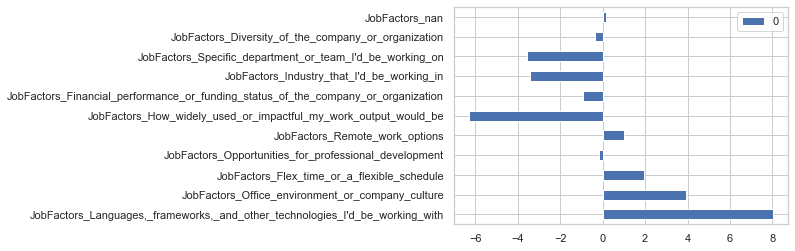

In [269]:
title_text = 'Job Factors'
xlimit = {0,75} # 
ylabel_text = 'Language'
pd.DataFrame(jobf_dev - jobf_ds).plot.barh()


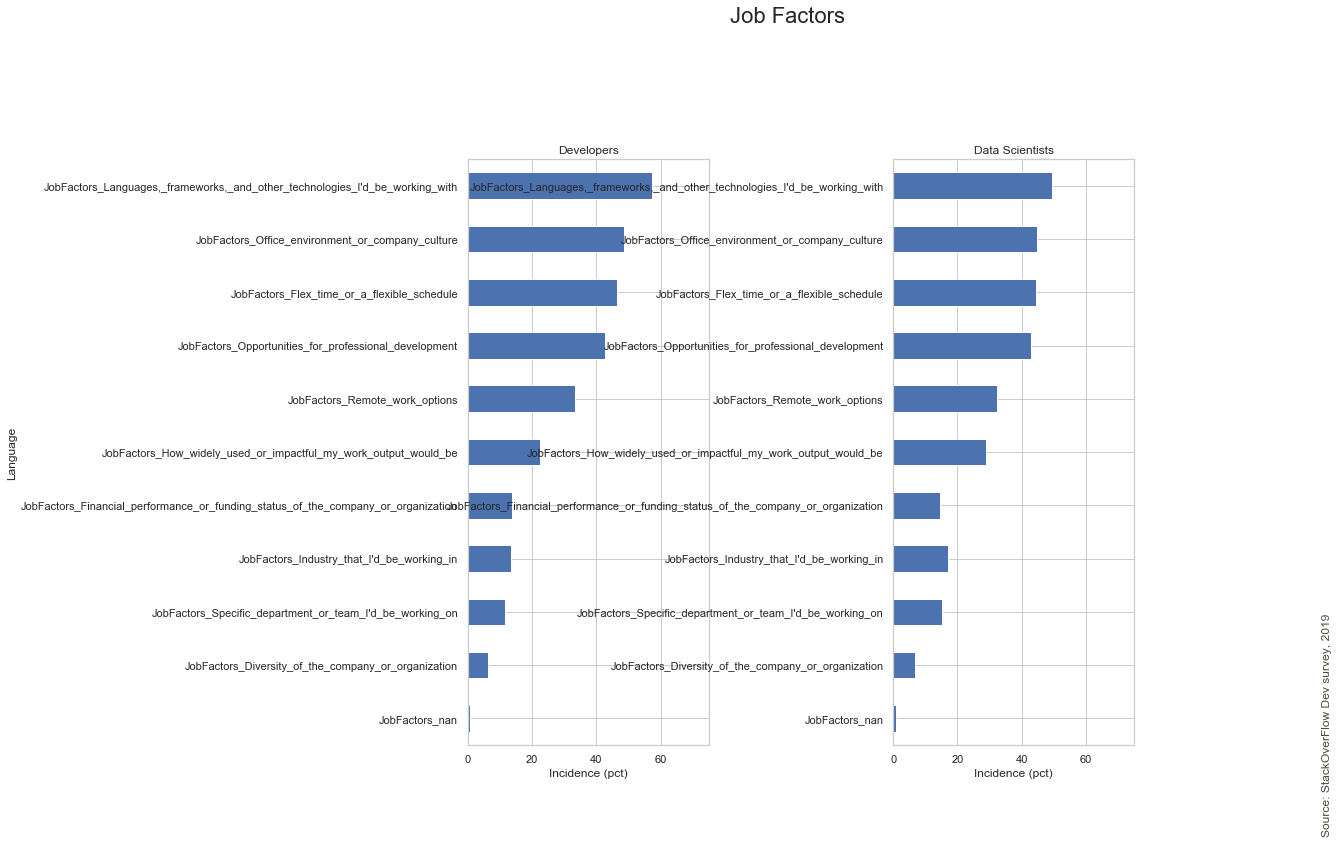

In [260]:
plot_dev_vs_df(jobf_dev,jobf_ds,title_text,xlimit,ylabel_text)

### Development Environment 

`DevEnviron`

In [52]:
devenv, devenv_cols = split_multiselect(df, 'DevEnviron')

In [53]:
# how many environs do each respondent claim :  almost 3!!!
devenv.sum(axis=1).describe()

count    65679.000000
mean         2.826946
std          1.599255
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         22.000000
dtype: float64

### Containers

`Containers`

In [54]:
containers, containers_cols = split_multiselect(df, 'Containers')



## and convert Now+Future into _FEELINGS_

- Love - use and want to continue next year
- Hate - use and want to stop next year
- Desire - don't use but want to next year


For the fields where multiple selections were possible (e.g.  `JobFactors`,`DevEnviron`, and `LanguageWorkedWith`), split the strings containing the multiple selections into a list of selections and then concatenate these lists into a single list (dropping any missing values in the process). 

We may also want to simplify these fields to reduce the length of category labels and to group similar categories into a single category apon further analysis.

Full list of the multi-select variables we will be addressing:
 `JobFactors`,`DevEnviron`,`Containers`,`WorkChallenge`, as well as the current/future pairs:
     `LanguageWorkedWith`, `LanguageDesireNextYear`, 
     `DatabaseWorkedWith`,`DatabaseDesireNextYear`, 
     `MiscTechWorkedWith`,`MiscTechDesireNextYear`, 
     `PlatformWorkedWith`, `PlatformDesireNextYear`,


In [55]:
def split_multiselect_love_hate(df, col, col_next, prefix):
    """Create a new dataframe that splits the values of multi-selection column col into individual selections and
    places each selection into a boolean column. This new dataframe can be merged into the original dataframe by
    Respondent (index)value.

    Args:
    df: dataframe. Dataframe containing the multi-selection field col.
    col:  column name
    col_next:  column name for "next year" multi-select
    prefix: how to name the new columns e.g. 'Lang' (&'LangNext') for 'LanguageWorkedWith'&'LanguageDesiredNextYear'

    Returns:
    out_df: dataframe. New dataframe giving split values of col.
        """

    unique_selects = {}
    # split the languages on ;
    # for language_set in survey['LanguageWorkedWith'].dropna().apply(lambda row: str(row).split(';')) :
    for select_set in df[col].apply(lambda row: str(row).split(';')):
        for select in select_set:
            if select not in unique_selects.keys():
                unique_selects[select] = 1
            else:
                unique_selects[select] += 1

    #     unique_selects_next = {}
    #     # split the languages on ;
    #     # for language_set in survey['LanguageWorkedWith'].dropna().apply(lambda row: str(row).split(';')) :
    #     for select_set in df[col_next].apply(lambda row: str(row).split(';')):
    #         for select in select_set:
    #             if select not in unique_selects_next.keys():
    #                 unique_selects_next[select] = 1
    #             else:
    #                 unique_selects_next[select] += 1

    # unique_selects.keys() == unique_selects_next.keys()
    un_sel = pd.Series(unique_selects).sort_values(ascending=False).copy()
    #un_sel_next = pd.Series(unique_selects_next).sort_values(ascending=False).copy()

    # out_df = pd.DataFrame()  # columns = unique_selects)
    out_df = df.loc[:, [col, col_next]]  # columns = unique_selects)

    select_na = df[col].isnull()
    select_na_next = df[col_next].isnull()

    new_cols = []
    # new_cols_next = []

    for sel in un_sel.index:
        # first lets
        # col_name = col[:25] + '_' + sel.replace(' ', '_')
        col_name = prefix + '_' + sel.replace(' ', '_')
        col_name_next = prefix + 'Next_' + sel.replace(' ', '_')
        col_name_love = prefix + 'Love_' + sel.replace(' ', '_')
        col_name_hate = prefix + 'Hate_' + sel.replace(' ', '_')
        col_name_desire = prefix + 'Desire_' + sel.replace(' ', '_')

        new_cols.append(col_name)
        new_cols.append(col_name_next)
        new_cols.append(col_name_love)
        new_cols.append(col_name_hate)
        new_cols.append(col_name_desire)

        if (sel == 'nan'):
            # this is a holding tally for how many non-selctions we have...
            # so should be true for respondents who have nans in other entries
            new_col = select_na
            new_col_next = select_na_next
            # these are pretty non-sensicle for nan
            # this is defensive... not nescessary?
            love = (~select_na)
            # this is defensive... not nescessary?
            hate = (~select_na)
            # any non-nan entries are "desired" but dangerous
            desire = (~select_na_next)

        else:
            new_col = ~select_na  # this is defensive... not nescessary?
            love = ~select_na  # this is defensive... not nescessary?
            hate = ~select_na  # this is defensive... not nescessary?

            selected = df[col].dropna().str.split(';').copy()
            # need to strip the nulls
            new_col[~select_na] = selected.apply(lambda x: sel in x)

            new_col_next = ~select_na_next  # this is defensive... not nescessary?
            desire = ~select_na_next
            selected_next = df[col_next].dropna().str.split(';').copy()
            # need to strip the nulls
            new_col_next[~select_na_next] = selected_next.apply(
                lambda x: sel in x)

            love = ((new_col == True) & (new_col_next == True))
            hate = ((new_col == True) & (new_col_next == False))
            desire = ((new_col == False) & (new_col_next == True))
            
            love[(new_col == False)]=np.nan # can only "love/hate" it if you alread do it..
            hate[(new_col == False)]=np.nan
            desire[(new_col == True)]=np.nan # can only "desire" it if you don't alread do it..
            
            # put the nonentries back in place
            new_col[select_na] = np.nan
            new_col_next[select_na_next] = np.nan

            love[select_na] = np.nan
            love[select_na_next] = np.nan
            hate[select_na] = np.nan
            desire[select_na_next] = np.nan

        out_df.loc[:, col_name] = new_col.astype('float64')
        out_df.loc[:, col_name_next] = new_col_next.astype('float64')

        out_df.loc[:, col_name_love] = love.astype('float64')
        out_df.loc[:, col_name_hate] = hate.astype('float64')
        out_df.loc[:, col_name_desire] = desire.astype('float64')

    return out_df, new_cols

### Languages 

`LanguageWorkedWith`, `LanguageDesireNextYear`, 


In [56]:
col = 'LanguageWorkedWith'
col_next = 'LanguageDesireNextYear'
prefix = 'Lang'
langs_df, Lang_cols = split_multiselect_love_hate(df, col, col_next, prefix)

In [57]:
langs_df.iloc[:, 0:15].head(35)

,LanguageWorkedWith,LanguageDesireNextYear,Lang_JavaScript,LangNext_JavaScript,LangLove_JavaScript,LangHate_JavaScript,LangDesire_JavaScript,Lang_HTML/CSS,LangNext_HTML/CSS,LangLove_HTML/CSS,LangHate_HTML/CSS,LangDesire_HTML/CSS,Lang_SQL,LangNext_SQL,LangLove_SQL
Respondent,,,,,,,,,,,,,,,
4,C;C++;C#;Python;SQL,C;C#;JavaScript;SQL,0.0,1.0,NaN,NaN,1.0,0.0,0.0,NaN,NaN,0.0,1.0,1.0,1.0
5,C++;HTML/CSS;Java;JavaScript;Python;SQL;VBA,HTML/CSS;Java;JavaScript;SQL;WebAssembly,1.0,1.0,1.0,0.0,NaN,1.0,1.0,1.0,0.0,NaN,1.0,1.0,1.0
7,HTML/CSS;JavaScript,HTML/CSS;JavaScript,1.0,1.0,1.0,0.0,NaN,1.0,1.0,1.0,0.0,NaN,0.0,0.0,NaN
9,Bash/Shell/PowerShell;C#;HTML/CSS;JavaScript;P...,Bash/Shell/PowerShell;C;HTML/CSS;JavaScript;Ru...,1.0,1.0,1.0,0.0,NaN,1.0,1.0,1.0,0.0,NaN,1.0,1.0,1.0
10,C#;Go;JavaScript;Python;R;SQL,C#;Go;JavaScript;Kotlin;Python;R;SQL,1.0,1.0,1.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,1.0,1.0,1.0
13,Bash/Shell/PowerShell;HTML/CSS;JavaScript;PHP;...,Bash/Shell/PowerShell;HTML/CSS;JavaScript;Rust...,1.0,1.0,1.0,0.0,NaN,1.0,1.0,1.0,0.0,NaN,1.0,1.0,1.0
14,C++,C++,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN
16,Bash/Shell/PowerShell;C#;HTML/CSS;JavaScript;T...,C#;HTML/CSS;JavaScript;TypeScript;WebAssembly;...,1.0,1.0,1.0,0.0,NaN,1.0,1.0,1.0,0.0,NaN,0.0,0.0,NaN
17,Bash/Shell/PowerShell;HTML/CSS;JavaScript;Type...,Bash/Shell/PowerShell;HTML/CSS;Java;JavaScript...,1.0,1.0,1.0,0.0,NaN,1.0,1.0,1.0,0.0,NaN,0.0,0.0,NaN


In [58]:
# We have to split the LanguageWorkedWith to get a proper picture
#languages = survey[survey['LanguageWorkedWith'].notnull()]

col = 'LanguageWorkedWith'
col_next = 'LanguageDesireNextYear'
prefix = 'Lang'

unique_selects = {}
# split the languages on ;
# for language_set in survey['LanguageWorkedWith'].dropna().apply(lambda row: str(row).split(';')) :
for select_set in df[col].apply(lambda row: str(row).split(';')):
    for select in select_set:
        if select not in unique_selects.keys():
            unique_selects[select] = 1
        else:
            unique_selects[select] += 1


unique_selects_next = {}
# split the languages on ;
# for language_set in survey['LanguageWorkedWith'].dropna().apply(lambda row: str(row).split(';')) :
for select_set in df[col_next].apply(lambda row: str(row).split(';')):
    for select in select_set:
        if select not in unique_selects_next.keys():
            unique_selects_next[select] = 1
        else:
            unique_selects_next[select] += 1

#unique_selects.keys() == unique_selects_next.keys()
un_sel = pd.Series(unique_selects).sort_values(ascending=False).copy()
un_sel_next = pd.Series(unique_selects_next).sort_values(ascending=False).copy()

Incidence of language mentions for now and last year indicate that Javascript is the top dawg but losing steam (though the TypeScript and WebAssembly flavors are up and coming), and traditional HTML/CSS also seems to be on the decline.   Go and Python seem to be steadily growing in interest, with Go, Kotlin, Clojure, Rust and Dart seeming to have emerging interest.  

In [59]:
# #pd.DataFrame([un_sel,un_sel_next])  # columns = unique_selects)
langs = pd.concat([un_sel, un_sel_next], axis=1, sort=False)
# langs.sum(axis=1)
langs.columns = [col, col_next]
langs['NowVsNextYear'] =(langs[col_next]-langs[col])
langs['pctInterestNext'] = (100*(langs[col_next]-langs[col])/langs[col])


In [60]:
# raw difference in mentions
langs.sort_values('NowVsNextYear',ascending=True)


,LanguageWorkedWith,LanguageDesireNextYear,NowVsNextYear,pctInterestNext
HTML/CSS,41911,27420,-14491,-34.575648
JavaScript,46945,34194,-12751,-27.161572
SQL,37235,25290,-11945,-32.080032
Java,26348,16583,-9765,-37.061637
Bash/Shell/PowerShell,24195,15428,-8767,-36.234759
PHP,17042,8636,-8406,-49.325197
C,11130,6694,-4436,-39.856244
C#,21657,17300,-4357,-20.118207
C++,13296,10434,-2862,-21.525271
VBA,2987,762,-2225,-74.489454


In [61]:
## This is how to merge the "splits" back into the main DF (for regressions...)
#df_ = df.merge(langs, how='outer', left_index=True, right_index=True)
#df_.shape

Now we need to look at what percentage of each language users LOVE, or HATE that language.  And what the raw percentage of non-users are interested in the language.

Lets plot as some horizontal bar graphs next to the raw incidence of language use for all Professionals and then with Developers and DataScientists broken out.



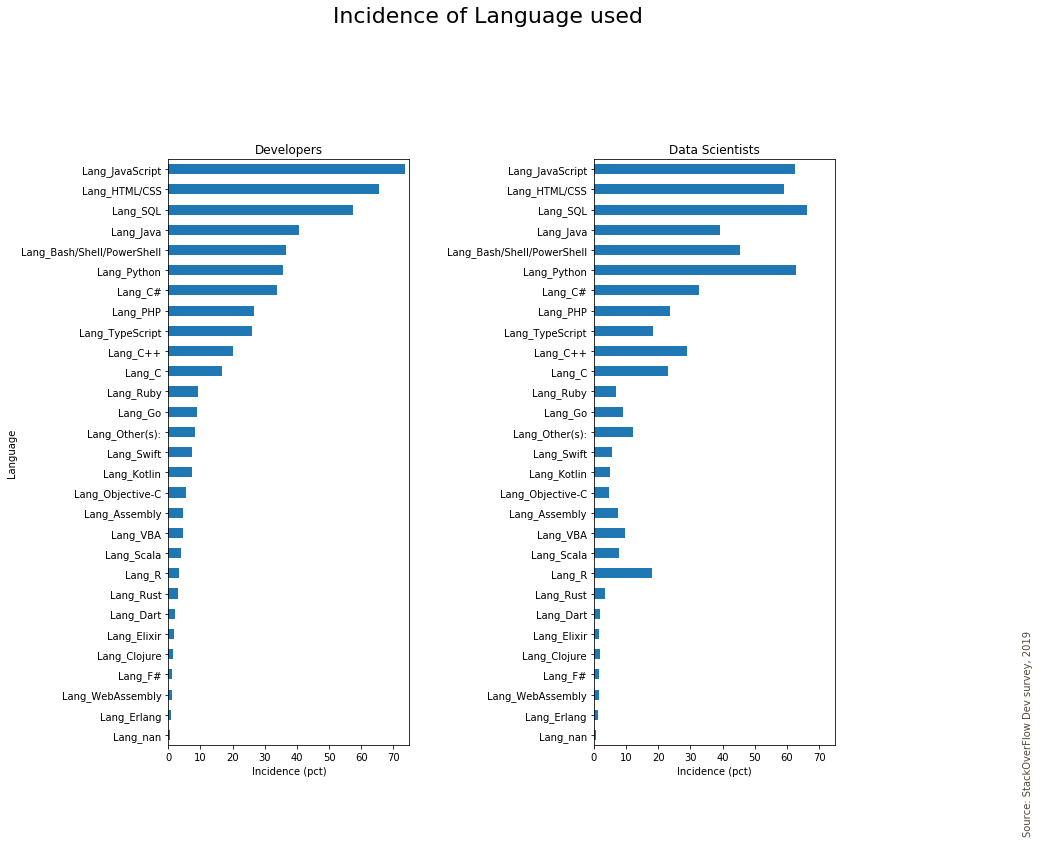

In [174]:
title_text = 'Incidence of Language used'
xlimit = {0,75} # 
ylabel_text = 'Language'

plot_dev_vs_df(lang_dev,lang_ds,title_text,xlimit,ylabel_text)

In [100]:
# DataFrame.hist(data, column=None, by=None, grid=True, 
#  xlabelsize=None, xrot=None, ylabelsize=None, 
#  yrot=None, ax=None, sharex=False, sharey=False, 
#  figsize=None, layout=None, bins=10,
               
               

In [68]:
langs = langs_df.filter(regex='Lang_')
#langs = langs.merge(df['DSorDV'], how='outer', left_index=True, right_index=True)
#langs.groupby('DSorDV').mean()




In [159]:
lang_dev = (100*langs[isDev].mean()).sort_values(ascending=True)
sorted_index = lang_dev.index
lang_ds = (100*langs[isDS].mean())
lang_ds = lang_ds[sorted_index]
lang_pct = (100*langs[isDev].mean()).sort_values(ascending=True)
lang_pct = lang_pct[sorted_index]


Lang_nan                       0.558521
Lang_Erlang                    1.335497
Lang_WebAssembly               1.635047
Lang_F#                        1.560160
Lang_Clojure                   2.034448
Lang_Elixir                    1.485272
Lang_Dart                      1.784823
Lang_Rust                      3.332501
Lang_R                        18.147778
Lang_Scala                     7.850724
Lang_VBA                       9.573140
Lang_Assembly                  7.638542
Lang_Objective-C               4.742886
Lang_Kotlin                    4.880180
Lang_Swift                     5.516725
Lang_Other(s):                12.306540
Lang_Go                        8.974039
Lang_Ruby                      7.014478
Lang_C                        23.115327
Lang_C++                      29.031453
Lang_TypeScript               18.397404
Lang_PHP                      23.801797
Lang_C#                       32.663505
Lang_Python                   62.893160
Lang_Bash/Shell/PowerShell    45.356965


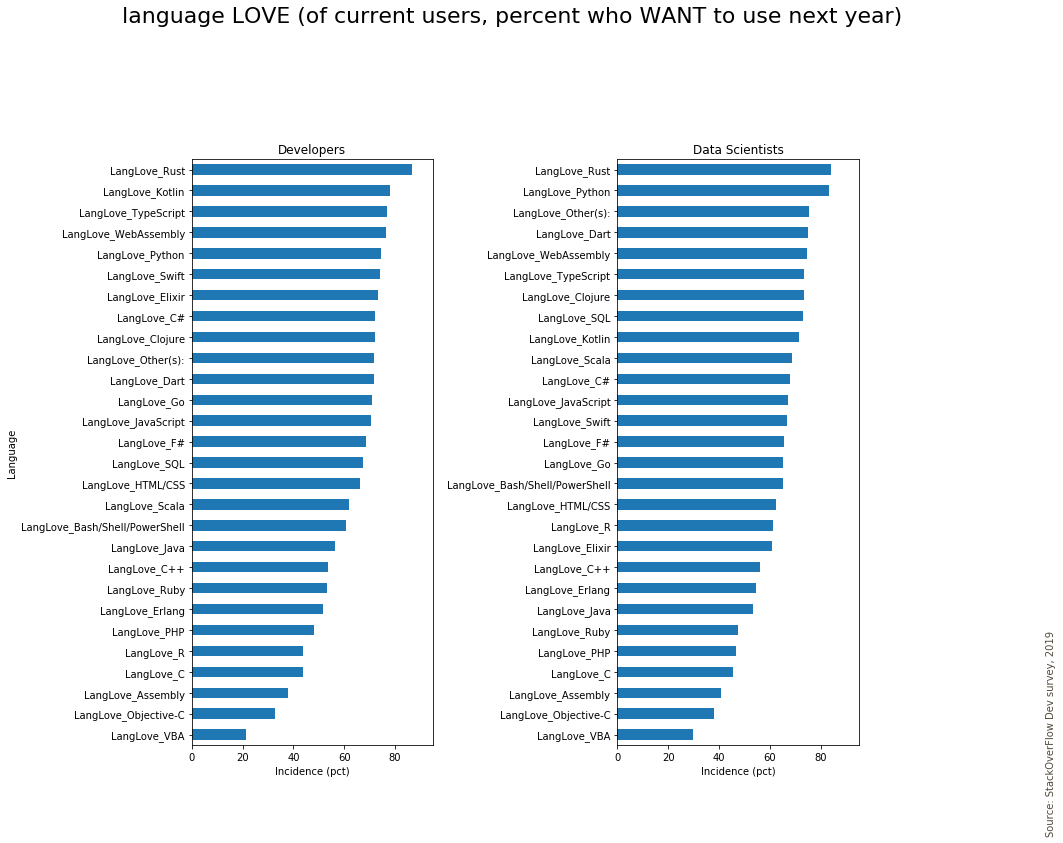

In [175]:
filt = langs_df.filter(regex='LangLove_')
love = filt.drop(columns='LangLove_nan')

love_dev = (100*love[isDev].mean()).sort_values(ascending=True)
love_ds = (100*love[isDS].mean()).sort_values(ascending=True)
#love_ds = love_ds[love_dev.index]
title_text = 'language LOVE (of current users, percent who WANT to use next year)'

xlimit = {0,95} # 
ylabel_text = 'Language'

plot_dev_vs_df(love_dev,love_ds,title_text,xlimit,ylabel_text)

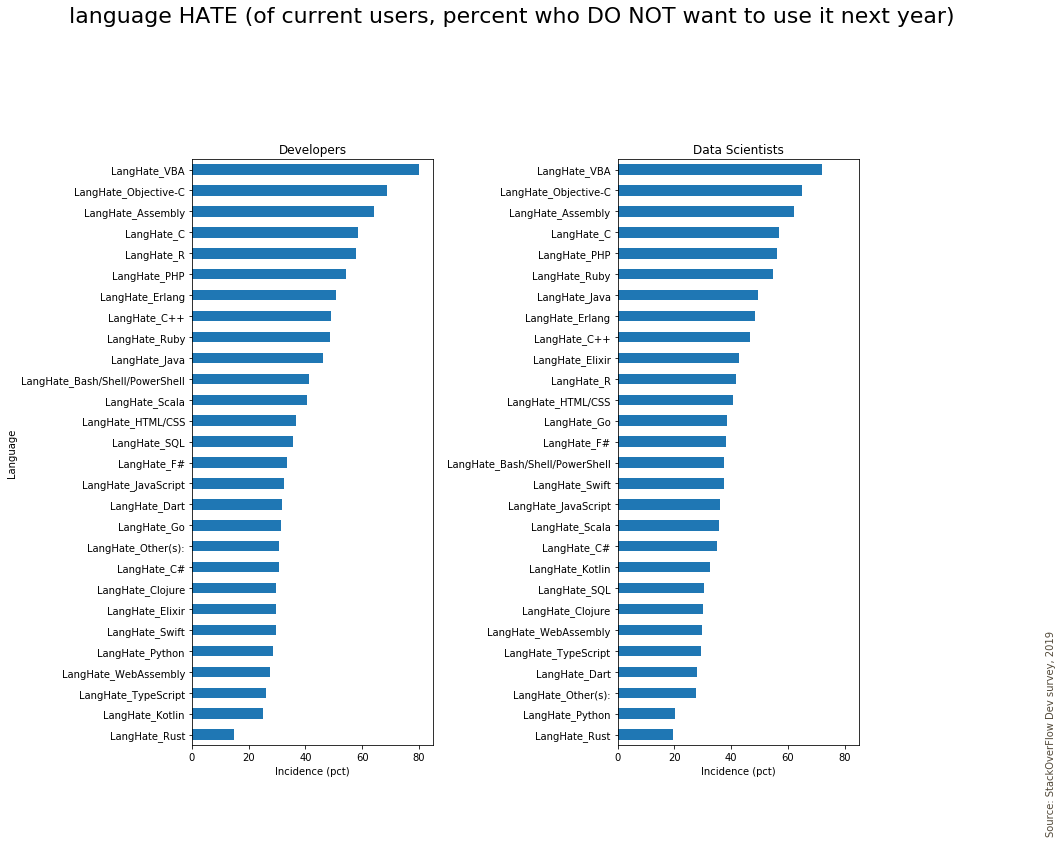

In [176]:
filt = langs_df.filter(regex='LangHate')
hate = filt.drop(columns='LangHate_nan')


hate_dev = (100*hate[isDev].mean()).sort_values(ascending=True)
hate_ds = (100*hate[isDS].mean()).sort_values(ascending=True)

title_text = 'language HATE (of current users, percent who DO NOT want to use it next year)'

xlimit = {0,85} # 
ylabel_text = 'Language'

plot_dev_vs_df(hate_dev,hate_ds,title_text,xlimit,ylabel_text)

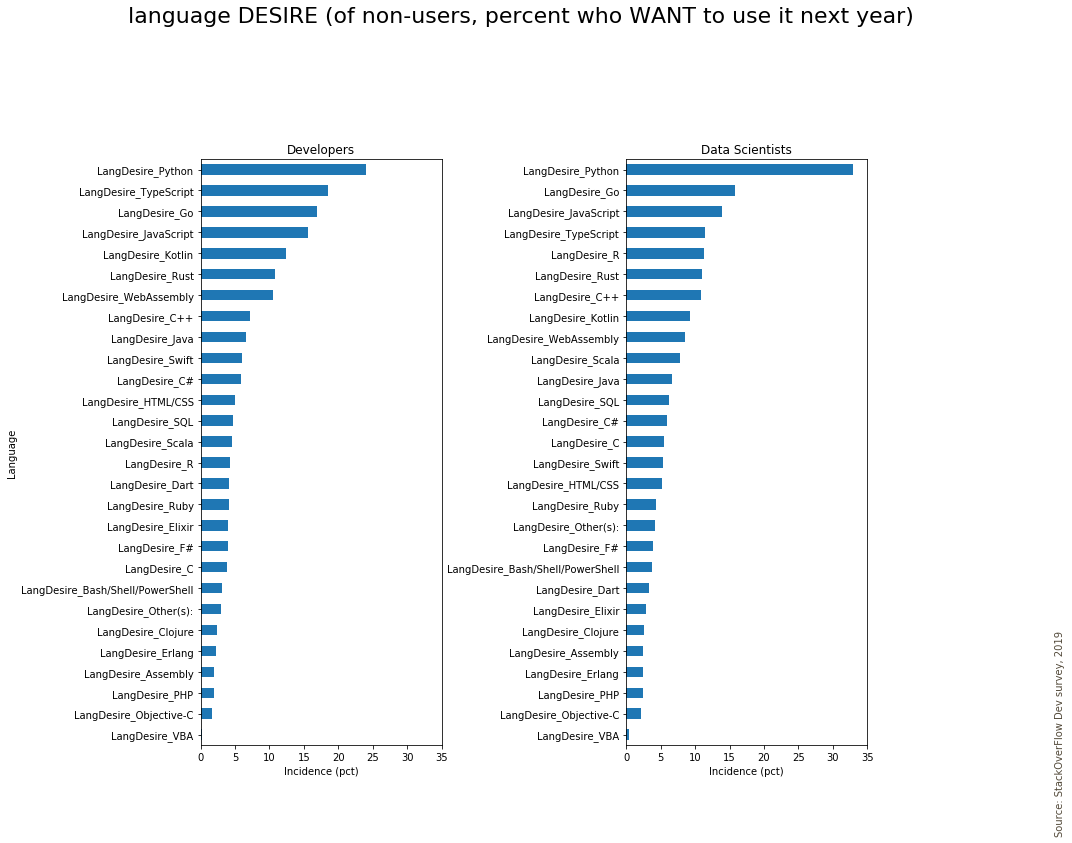

In [177]:
filt = langs_df.filter(regex='LangDesire')
desire = filt.drop(columns='LangDesire_nan')

des_dev = (100*desire[isDev].mean()).sort_values(ascending=True)
des_ds = (100*desire[isDS].mean()).sort_values(ascending=True)

title_text = 'language DESIRE (of non-users, percent who WANT to use it next year)'

xlimit = {0,35} # 
ylabel_text = 'Language'

plot_dev_vs_df(des_dev,des_ds,title_text,xlimit,ylabel_text)

In [178]:
col = 'PlatformWorkedWith'
col_next = 'PlatformDesireNextYear'
prefix = 'Platform'
platform_df, Platform_cols = split_multiselect_love_hate(df, col, col_next, prefix)

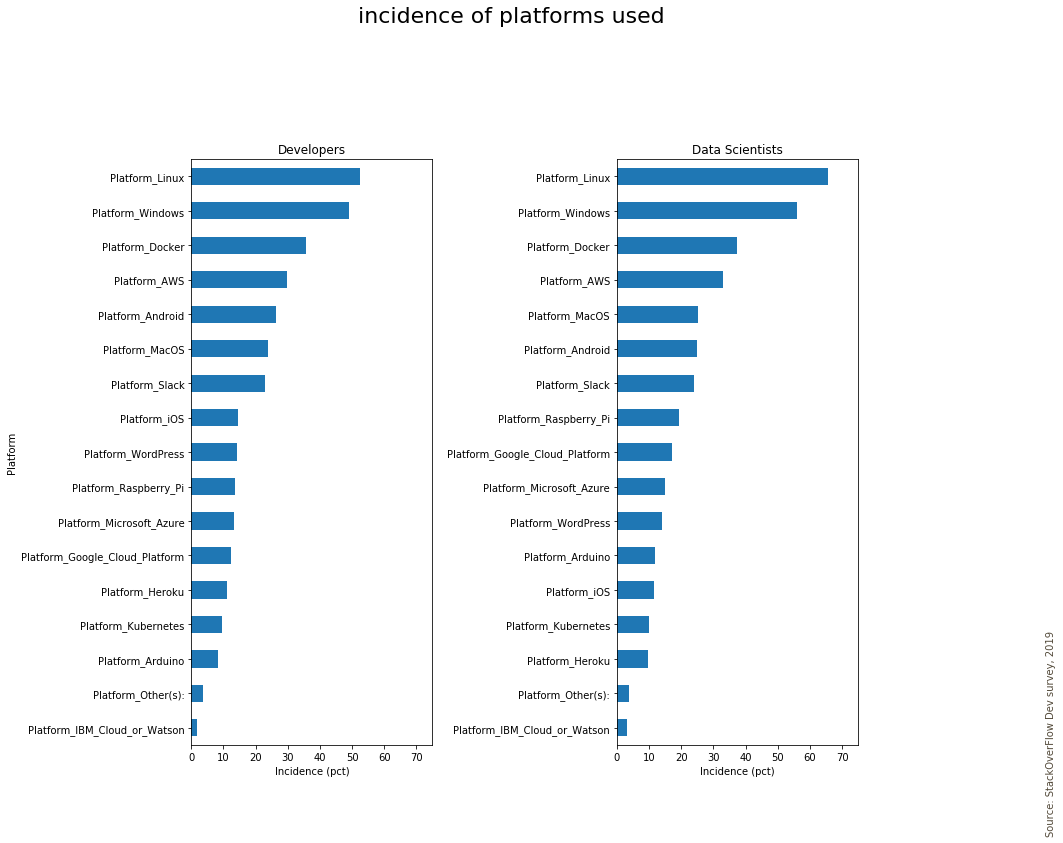

In [180]:
plats = platform_df.filter(regex='Platform_')
plats = plats.drop(columns='Platform_nan')

plats_dev = (100*plats[isDev].mean()).sort_values(ascending=True)
plats_ds = (100*plats[isDS].mean()).sort_values(ascending=True)

title_text = 'incidence of platforms used'
xlimit = {0,75} # 
ylabel_text = 'Platform'
plot_dev_vs_df(plats_dev,plats_ds,title_text,xlimit,ylabel_text)

In [172]:
# plats = platform_df.filter(regex='PlatformDesire_')
# plats = plats.drop(columns='PlatformDesire_nan')

# platsd_dev = (100*plats[isDev].mean()).sort_values(ascending=True)
# platsd_ds = (100*plats[isDS].mean()).sort_values(ascending=True)

# platsd_dev.plot.barh(figsize=(10, 10))

# platsd_ds.plot.barh(figsize=(10, 10))

In [182]:
col = 'DatabaseWorkedWith'
col_next = 'DatabaseDesireNextYear'
prefix = 'DB'
db_df, DB_cols = split_multiselect_love_hate(df, col, col_next, prefix)

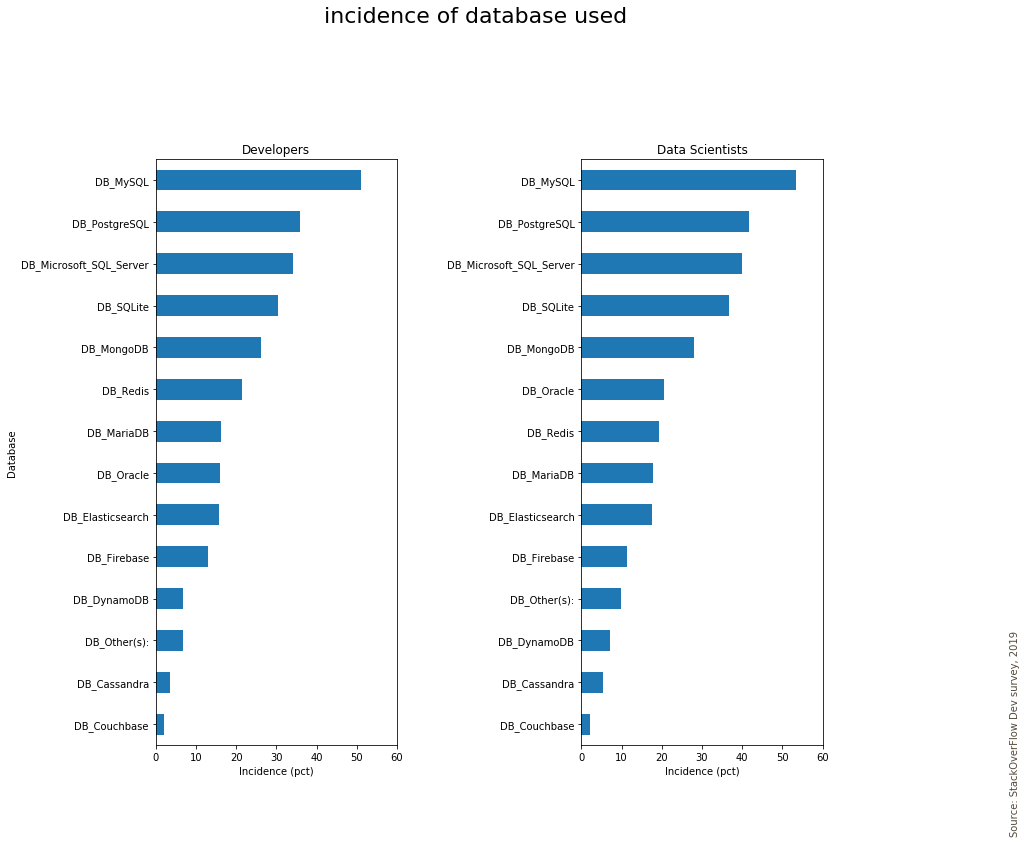

In [184]:
dbs = db_df.filter(regex='DB_')
dbs = dbs.drop(columns='DB_nan')

dbs_dev = (100*dbs[isDev].mean()).sort_values(ascending=True)
dbs_ds = (100*dbs[isDS].mean()).sort_values(ascending=True)

title_text = 'incidence of database used'
xlimit = {0,60} # 
ylabel_text = 'Database'
plot_dev_vs_df(dbs_dev,dbs_ds,title_text,xlimit,ylabel_text)

In [185]:
col = 'MiscTechWorkedWith'
col_next = 'MiscTechDesireNextYear'
prefix = 'Tech'
tech_df, Tech_cols = split_multiselect_love_hate(df, col, col_next, prefix)

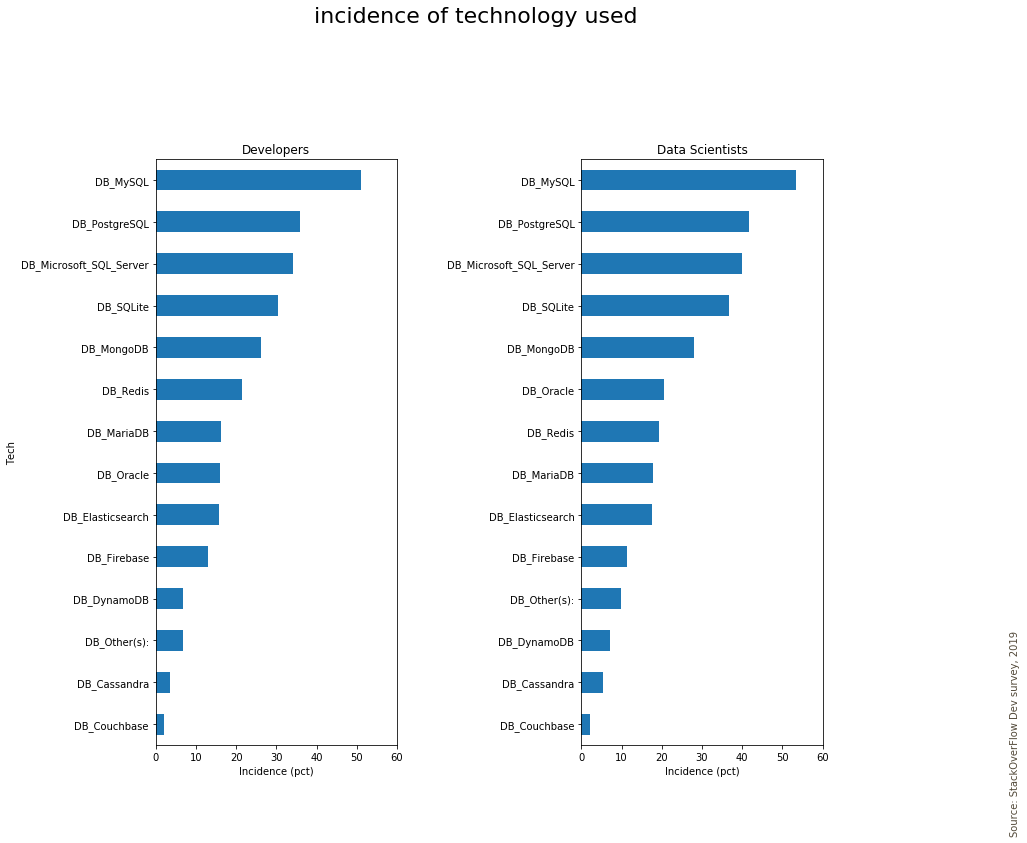

In [186]:
techs = tech_df.filter(regex='Tech_')
techs = techs.drop(columns='Tech_nan')

techs_dev = (100*techs[isDev].mean()).sort_values(ascending=True)
techs_ds = (100*techs[isDS].mean()).sort_values(ascending=True)

title_text = 'incidence of technology used'
xlimit = {0,60} # 
ylabel_text = 'Tech'
plot_dev_vs_df(dbs_dev,dbs_ds,title_text,xlimit,ylabel_text)

---

dont 

---

go 

---

below

---

here

---

throw out everything except a simple df

In [ ]:
import sklearn
from sklearn import svm, preprocessing

df = sklearn.utils.shuffle(df) # always shuffle your data to avoid any biases that may emerge b/c of some order.

X = df.drop("price", axis=1).values
X = preprocessing.scale(X)
y = df["price"].values

test_size = 200

X_train = X[:-test_size]
y_train = y[:-test_size]

X_test = X[-test_size:]
y_test = y[-test_size:]

clf = svm.SVR(kernel = 'linear')
#clf = svm.SVR(kernel = 'rbf')

clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

for X,y in list(zip(X_test, y_test))[:10]:
    print(f"model predicts {clf.predict([X])[0]}, real value: {y}")

TypeError: Must pass values for either `x` or `y`

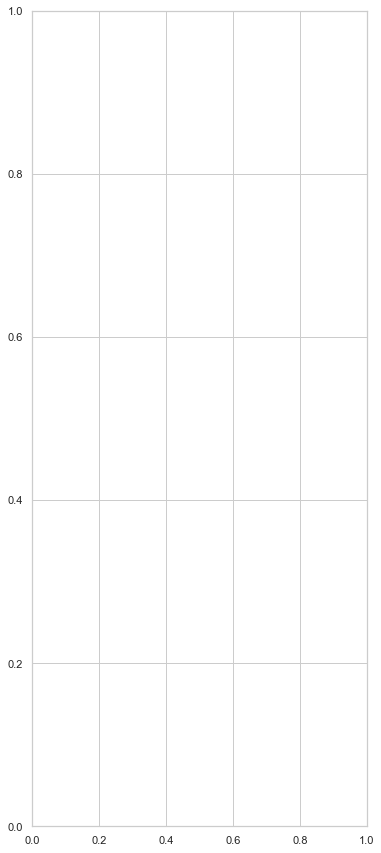

In [189]:
#import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

sns.set_color_codes("pastel")
p = sns.countplot(data=techs)

#sns.barplot(x="MainBranch", y="abbrev", data=df, label="Count", color="b")


# Plot the crashes where alcohol was involved
# sns.set_color_codes("muted")
# sns.barplot(x="alcohol", y="abbrev", data=crashes,
#            label="Alcohol-involved", color="b")

# Add a legend and informative axis label
#ax.legend(ncol=2, loc="lower right", frameon=True)
# ax.set(xlim=(0, 24), ylabel="",
#       xlabel="Automobile collisions per billion miles")
#sns.despine(left=True, bottom=True)

In [ ]:
 
# Generate 1000 random values.
x = np.random.normal(10, 5, 1000)
y = np.random.normal(11,10,1000)
# Plot them as a histogram.
plt.hist(x) 
plt.show()# Same data, this time normed, using density.
plt.hist(x, density=True, color='blue', bins=np.arange(-10, 40), alpha=.5) 
plt.hist(y, density=True, color='red', bins=np.arange(-10, 40), alpha=.5)
plt.title('Normed histograms')
plt.xlabel('Random Values')

plt.show()


print(set(df['region'].values.tolist()))
    
    region_df = df.copy()[df['region']==region]




graph_df = pd.DataFrame()

for region in df['region'].unique():
    region_df = df.copy()[df['region']==region]
    region_df.set_index('Date', inplace=True)
    region_df.sort_index(inplace=True)
    region_df[f"{region}_price25ma"] = region_df["AveragePrice"].rolling(25).mean()

    if graph_df.empty:
        graph_df = region_df[[f"{region}_price25ma"]]  # note the double square brackets! (so df rather than series)
    else:
        graph_df = graph_df.join(region_df[f"{region}_price25ma"])

graph_df.tail()



In [115]:
# create figure and axis
fig, ax = plt.subplots()
# plot histogram


ax.hist(desireDS,bins=30, alpha=0.3, density=True, range={0,1000000.}, color='r')
# set title and labels
ax.set_title('df')
ax.set_xlabel('muney')
ax.set_ylabel('Frequency')
ax.hist(desireDev,bins=30, alpha=0.3, density=True, range={0,1000000.},color='b' )


# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

sns.set_color_codes("pastel")
p = sns.countplot(data=df, x='MainBranch')

p = sns.countplot(data=df,
                  y = 'Category',
                  hue = 'DSorDV')


# Plot the total crashes
#sns.barplot(x="MainBranch", y="abbrev", data=df, label="Count", color="b")

# Plot the crashes where alcohol was involved
# sns.set_color_codes("muted")
# sns.barplot(x="alcohol", y="abbrev", data=crashes,
#            label="Alcohol-involved", color="b")

# Add a legend and informative axis label
#ax.legend(ncol=2, loc="lower right", frameon=True)
# ax.set(xlim=(0, 24), ylabel="",
#       xlabel="Automobile collisions per billion miles")
sns.despine(left=True, bottom=True)

###  Databases, Platforms, and Misc Tech

      `DatabaseWorkedWith`,`DatabaseDesireNextYear`, 
     `MiscTechWorkedWith`,`MiscTechDesireNextYear`, 
     `PlatformWorkedWith`, `PlatformDesireNextYear`,

NameError: name 'now' is not defined

In [ ]:
df.pivot_table(['Total day calls', 'Total eve calls', 'Total night calls'],
               ['Area code'], aggfunc='mean')

pd.crosstab(df['Churn'], df['Voice mail plan'], normalize=True)


# Plotting a bar graph of the number of stores in each city, for the first ten cities listed
# in the column 'City'
city_count = df['City'].value_counts()
city_count = city_count[:10, ]
plt.figure(figsize=(10, 5))
sns.barplot(city_count.index, city_count.values, alpha=0.8)
plt.title('Starbucks in top 10 cities in the World')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('city', fontsize=12)
plt.show()